In [71]:
import os
import sys
import pandas as pd
from py2cytoscape import cyrest
from IPython.display import Image
%matplotlib inline
from py2cytoscape.cyrest.base import api

### check cytoscape connection and setup

In [72]:
cytoscape=cyrest.cyclient()
cytoscape.version()

apiVersion v1
cytoscapeVersion 3.7.2


In [73]:
cytoscape.session.new()

In [74]:
cytoscape.vizmap.apply(styles='default')

{'views': []}

## filter data

#### filter expression dataset

In [75]:
# read data into pandas dataframe
times = pd.read_csv('./data/Bendjilali2017G3.tsv',sep='\t')
print(times.shape)
# filter expression data on autocor and DESeq ajdusted values <0.05
times = times[
    (times['autocor.adj']<0.05) &
    (times['DESeq.adj']<0.05)
]
print(times.shape)
# write the filtered expression data to tsv
times.to_csv('./data/filtered_exp.tsv',sep='\t',index=False)

(7140, 11)
(467, 11)


#### select nodes with significant expression

In [76]:
# read network into pandas dataframe
network = pd.read_csv('./data/Yu2008Science.tsv',sep='\t',header=None)
print(network.shape)
# select pairs if both occur in the filtered expression data 
network = network[(network[0].isin(times['gene'])) & (network[1].isin(times['gene']))]
print(network.shape)
# write filtered network to tsv
network.to_csv('./data/network_filtered.tsv',index=False,header=False, sep='\t')

(1809, 3)
(33, 3)


## Load data into cytoscape

#### load network

In [77]:
res = api(namespace='network',command='import file',
    PARAMS ={
     "file": "/home/joeri/Documents/coding_projects/cytohack/data/network_filtered.tsv",
    "indexColumnSourceInteraction": "1",
    "indexColumnTargetInteraction": "2",
    "indexColumnTypeInteraction": "3",
    }
)
network = res['networks'][0]

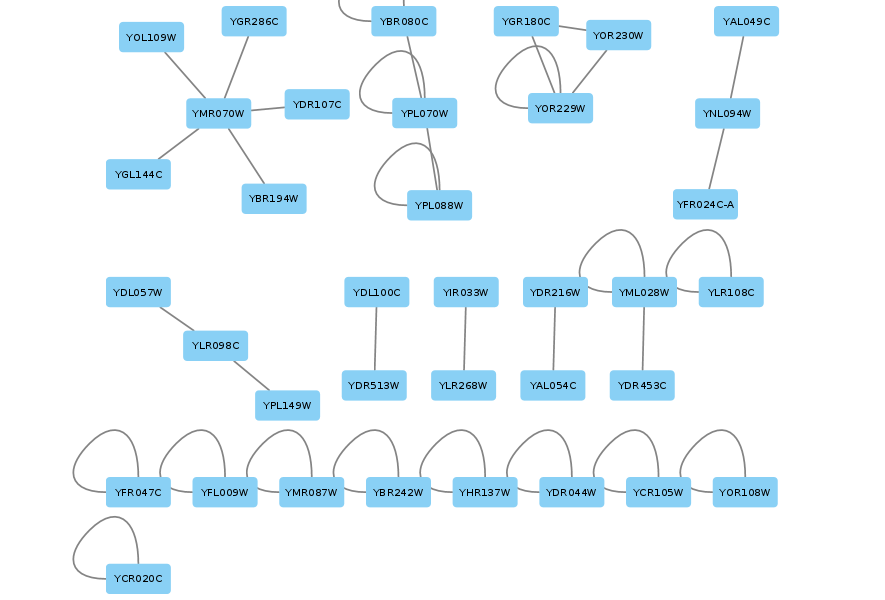

In [78]:
# zoom view to fit network content
cytoscape.view.fit_content()
# get the figure from the created network
fig = cytoscape.networks.getFirstImageAsPng(networkId=network,h=None)
Image(fig.content)

#### load time series table into omicsvisualizer

In [79]:
api(namespace='ov',command='load',
    PARAMS ={
     "file": "/home/joeri/Documents/coding_projects/cytohack/data/filtered_exp.tsv",
    "keyColumnIndex": "1",
    "startLoadRow":'1',
    "dataTypeList":"s,d,d,d,d,d,d,d,d,d,d",
    "newTableName":'times',
    }
)


#### connect the ov table to the network

In [80]:
api(namespace='ov',command='connect',
    PARAMS ={
    'mappingColNet':'shared name',
    'mappingColTable':'gene',
    }
)

### create donut visualization of time series expression data

In [81]:
# apply donut visualization
api(namespace='ov',command='viz apply outer continuous',
    PARAMS ={
    "attributes":'min0,min5,min10,min30,min60,min120,min180,min240',
    "transpose":'true',
    "rangeMax":'4000',
    "rangeMid":'2000',
    "rangeMin":'0',
    }
)

In [82]:
# zoom view to fit network content
cytoscape.view.fit_content()
# get the figure from the created network
fig = cytoscape.networks.getFirstImageAsPng(networkId=network,h=None)


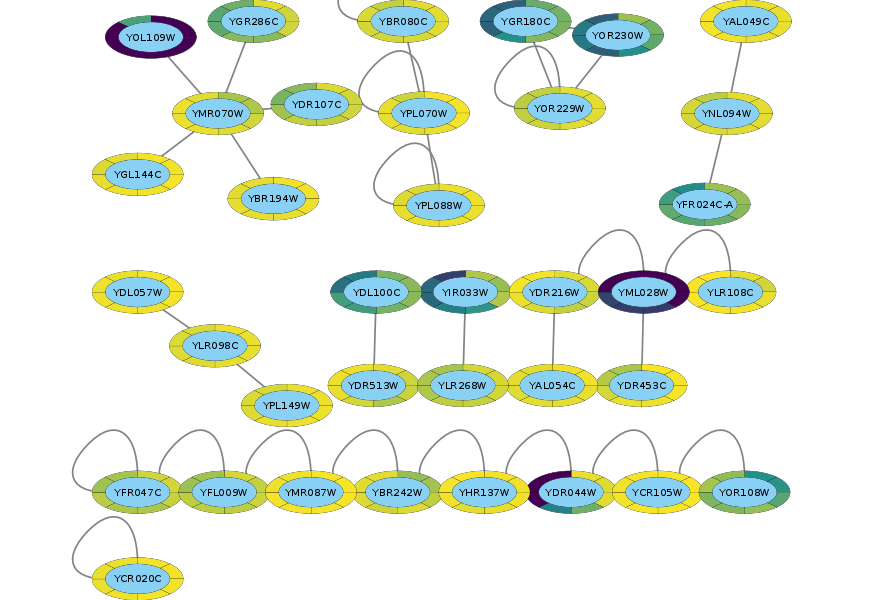

In [83]:
Image(fig.content)

In [69]:
cytoscape.view.fit_content()

### NOT USED: filter the omics visualizer table
did the filtering in python, but kept this as a reference

**filter for autocor.adj**

In [129]:
api(namespace='ov',command='filter',
   PARAMS={
       'filter':"(autocor.adj,LOWER,0.05)",
       'tableName':'times'
   })

**filter for DESeq.adj**

In [130]:
api(namespace='ov',command='filter',
   PARAMS={
       'filter':"(DESeq.adj,LOWER,0.05)",
       'tableName':'times'
   })